# Generate network of genes and proteins up/down regulated by NANOG induction

Based on data from Tiana et al. Science Advances, 2022, in which the authors "aimed to understand the role of Oct4 and Nanog beyond pluripotency. We have characterized the transcriptional changes caused by gain of function of these factors and determined that they regulate many developmental regulators in a dual fashion, repressing their expression at E7.5 and activating them at E9.5"

Here, I combined their list of up/down regulated genes with protein-protein interaction and transcription factor databases to generate a network that describes connections between the different genes and their respective proteins.

In [1]:
import json
import pickle
import networkx as nx

In [2]:
from matplotlib import pyplot as plt

In [3]:
from collections import defaultdict, Counter

In [ ]:
## Match genes in Tiana et al data to their respective proteins

In [ ]:
gene_protein = pickle.load(open('../data/gene_protein_ids.pickle','rb'))

In [ ]:
protein_gene = dict()
for gene, protein in gene_protein.items():
    protein_gene[protein] = gene

In [ ]:
data_genes = []
datafile = open('../data/tiana_etal_science_advances_2022.csv')
header = next(datafile)
for line in datafile:
    s=line.strip().split(',')
    data_genes.append(s[0])

protein_gene_matches = 0
for gene in data_genes:
    if gene in gene_protein:
        protein_gene_matches += 1 
#         protein = gene_protein[gene]
#         gene_graph.add_edge(('gene', gene), ('protein', protein), type='gene_protein')

print('num genes in data               ', len(data_genes))
print('num proteins matched to genes   ', protein_gene_matches)

## Protein protein interaction data (STRINGdb)

In [7]:
# Extract and transform relevant data from STRING database dump file
def process_line(line):
    s = line.strip().split(' ')
    # Remove the 10090 prefix that indicates this is from the mouse species data in STRING
    s[0] = s[0].split('.')[1]
    s[1] = s[1].split('.')[1]
    for i,c in enumerate(s[2:]):
        s[i+2] = int(c)
        
    return s

In [8]:
columns = [
    'protein1',
    'protein2',
    'neighborhood',
    'fusion',
    'cooccurence',
    'coexpression',
    'experimental',
    'database',
    'textmining',
    'combined_score']

In [9]:
for c in list(enumerate(columns)): print(c)

(0, 'protein1')
(1, 'protein2')
(2, 'neighborhood')
(3, 'fusion')
(4, 'cooccurence')
(5, 'coexpression')
(6, 'experimental')
(7, 'database')
(8, 'textmining')
(9, 'combined_score')


In [10]:
# Use linux utility wc to quickly count the number of lines in the string data file
n = !wc -l ../data/string_db_mouse_ppi.txt
n = int(n[0].split(' ')[0])

step = int(n/20)

In [79]:
# Create a networkx graph from the string data
string_file = open('../data/string_db_mouse_ppi.txt')

header = next(string_file)

string_unmapped = 0

string_graph = nx.Graph()
for i,line in enumerate(string_file):
    line = process_line(line)
    src = line[0]
    tgt = line[1]
    coexpression = line[5]
    experimental = line[6]
    
    string_graph.add_edge(src, tgt,
                          coexpression=coexpression, experimental=experimental)
#     if src in protein_gene and tgt in protein_gene:
#         src_gene = protein_gene[src]
#         tgt_gene = protein_gene[tgt]
#         string_graph.add_edge(src_gene, tgt_gene,
#                               coexpression=coexpression, experimental=experimental)
#     else:
#         string_unmapped += 1
    # Print progress
    if i%step==0:
        print(int(i/n*100), flush=True)

0
4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99


In [80]:
len(string_graph)

21317

In [81]:
pickle.dump(string_graph, open('../data/string_graph.pickle','wb'))

## Remove low quality edges from graph

In [82]:
filtered_graph = nx.Graph()
for edge in string_graph.edges(data=True):
    attrs = edge[2]
#     if attrs['coexpression'] > 250:
#         filtered_graph.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], 
#                                 type='coexpression', weight=attrs['coexpression'])
    if attrs['experimental'] > 250:
        filtered_graph.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], 
                                directed=False, effect=None, type='protein_protein', 
                                evidence='experimental', weight=attrs['experimental'])

In [83]:
filtered_graph.number_of_edges()

268575

In [84]:
filtered_graph.number_of_nodes()

14671

## Load Transcription factors (TRRUST)

In [85]:
# These data files provide mappings between gene/protein names (TP53, NANOG, etc) to their Ensembl ID
protein_names = pickle.load(open('../data/protein_names.pickle','rb'))
gene_names = pickle.load(open('../data/gene_names.pickle','rb'))

In [125]:
tf_graph = nx.DiGraph()
n_tfs = 0
for line in open('../data/trrust_rawdata.mouse.tsv'):
    s = line.split('\t')
    src, tgt, etype, dois = s
    src = src.upper()
    tgt = tgt.upper()
    if etype=='Activation':
        effect = 'a'
    elif etype=='Repression':
        effect = 'i'
    else:
        effect = None
    # Each protein and gene name can map to multiple different Ensembl ID's.
    # For example, each a protein can be translated from multiple different splice variants, each of which has a 
    # unique Ensembl ID
    # Below, we create connections between all ensembl id's associated with each source/target name
    if src in protein_names and tgt in protein_names:
        src_ids = protein_names[src]
        tgt_ids = protein_names[tgt]
        for src_id in src_ids:
            for tgt_id in tgt_ids:
                tf_graph.add_edge(src_id, tgt_id, directed=True, effect=effect, weight=None,
                                  type='tf', dois=dois.strip())
    n_tfs+=1

In [126]:
tf_graph.number_of_nodes()

8534

In [127]:
tf_graph.number_of_edges()

105539

In [128]:
n_tfs

7057

## Combine protein-protein, transcription factors, and gene-protein interactions

In [129]:
# data_proteins = [node for node in gene_graph.nodes() if node[0]=='protein']

# data_genes = [node for node in gene_graph.nodes() if node[0]=='gene']

In [130]:
data_proteins = []
unmapped_data_genes = 0
for gene in data_genes:
    if gene in gene_protein:
        data_proteins.append(gene_protein[gene])
    else:
        unmapped_data_genes += 1
print(len(data_proteins), unmapped_data_genes)

1489 149


In [131]:
data_protein_interactions = filtered_graph.subgraph(data_proteins)

In [132]:
data_protein_interactions.number_of_nodes()

119

In [133]:
data_protein_interactions.number_of_edges()

248

In [134]:
data_tfs = tf_graph.subgraph(data_proteins)

In [135]:
data_tfs.number_of_nodes()

399

In [136]:
data_tfs.number_of_edges()

380

In [137]:
combined = nx.compose(data_tfs, data_protein_interactions)

In [138]:
combined.number_of_nodes()

424

In [139]:
combined.number_of_edges()

463

## Filter the combined graph to only the largest connected component

The rationale for this is that most of the disconnected components are extremely small in size (i.e. a single gene-protein pair), meaning that we don't have good prior knowledge for how they are regulated by other genes/proteins in the system.  

Instead we are only interested in the "core" set of interacting genes. These are presumably the set that are most strongly influenced by the induction of NANOG, while the genes/proteins in the disconnected components might be regulated primarily by other systems.

In [140]:
# Size of the connected components of the network
sorted([len(cc) for cc in nx.weakly_connected_components(combined)], reverse=True)[:10]

[262, 2, 2, 2, 2, 2, 2, 1, 1, 1]

In [141]:
# Grab the subgraph corresponding to the largest connected component
connected_graph_nodes = sorted([cc for cc in nx.weakly_connected_components(combined)], key=len, reverse=True)[0]
connected_graph = combined.subgraph(connected_graph_nodes)

In [142]:
# Basic quality checks to ensure that the connected component subgraph is correct
print(nx.is_weakly_connected(connected_graph))
print(nx.number_of_nodes(connected_graph))
print(nx.number_of_edges(connected_graph))

True
262
456


In [143]:
from collections import Counter
from pprint import pprint

## Remove nodes with outdegree = 0

In [144]:
removal_count = 1 # placeholder

filtered_graph = connected_graph.copy()

# If a node (A) has only out edge is to another node (B) that is removed, then A will have zero outdegree after B 
# is removed. Then, we have to run another pass to remove A. We repeat this process until all 
# nodes have outdegree > 0
output_nodes = []
while removal_count > 0:
    zeros = []
    for node in filtered_graph.nodes:
#         in_degree = filtered_graph.in_degree[node]
        out_degree = filtered_graph.out_degree[node]
#         if in_degree == 0 or out_degree == 0:
        if out_degree == 0:
            zeros.append(node)
    filtered_graph.remove_nodes_from(zeros)
    removal_count = len(zeros)
    output_nodes += zeros
    print(removal_count)

111
25
6
1
0


In [145]:
print(filtered_graph.number_of_nodes())
print(filtered_graph.number_of_edges())
print(len(output_nodes))

119
248
143


In [146]:
pickle.dump(output_nodes, open('output_nodes.pickle','wb'))

In [147]:
filtered_graph.number_of_nodes()

119

In [148]:
filtered_graph.number_of_edges()

248

### Statistics of largest connected component

In [149]:
# Edge types in the giant component
edge_types = Counter()
for edge in filtered_graph.edges(data=True):
    edge_types[edge[2]['type']] += 1
pprint(edge_types.most_common())

[('tf', 162), ('protein_protein', 86)]


In [150]:
# Average degree
nx.number_of_edges(filtered_graph)/nx.number_of_nodes(filtered_graph)

2.0840336134453783

### Degree distribution of largest filtered component

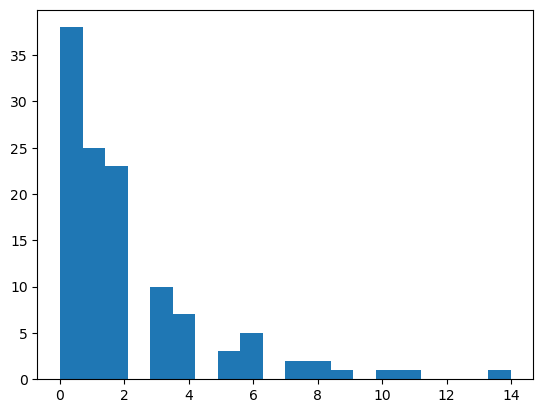

In [151]:
# in degree
plt.hist(dict(filtered_graph.in_degree).values(), bins=20);

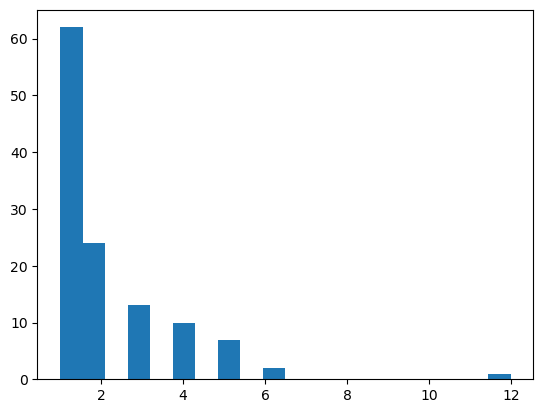

In [152]:
# out degree
plt.hist(dict(filtered_graph.out_degree).values(), bins=20);

In [153]:
for x in Counter(dict(filtered_graph.in_degree).values()).most_common():
    print(x)

(0, 38)
(1, 25)
(2, 23)
(3, 10)
(4, 7)
(6, 5)
(5, 3)
(8, 2)
(7, 2)
(9, 1)
(14, 1)
(11, 1)
(10, 1)


In [154]:
for x in Counter(dict(filtered_graph.out_degree).values()).most_common():
    print(x)

(1, 62)
(2, 24)
(3, 13)
(4, 10)
(5, 7)
(6, 2)
(12, 1)


## Check that NANOG is in the largest connected component

In [155]:
nanog_ids = protein_names['NANOG']
for nanog_id in nanog_ids:
    nanog_id = nanog_id
    if nanog_id in connected_graph:
        print(nanog_id, filtered_graph.in_degree[nanog_id], filtered_graph.out_degree[nanog_id])

ENSMUSP00000012540 14 5


## Export connected component in gephi compatible format

In [156]:
nodefile = open('../data/connected_graph_nodes.csv','w')
nodefile.write('Id,data\n')
for node in filtered_graph.nodes():
    nodefile.write(node + '\n')
nodefile.close()

In [157]:
set(attrs.keys())

{'directed', 'effect', 'evidence', 'type', 'weight'}

In [158]:
all_attrs = set()
for edge in filtered_graph.edges(data=True):
    src, tgt, attrs = edge
    for key in attrs.keys():
        all_attrs.add(key)

In [159]:
all_attrs = list(all_attrs)

In [160]:
edgefile = open('../data/connected_graph_edges.csv','w')
edgefile.write('Source,Target,'+','.join(all_attrs)+'\n')
for edge in filtered_graph.edges(data=True):
    src, tgt, attrs = edge
    line = [src, tgt]
    for attr in all_attrs:
        if attr in attrs:
            line.append(attrs[attr])
        else:
            line.append('')

    edgefile.write(','.join([str(_) for _ in line]) + '\n')
edgefile.close()

## Export graph as pickle

In [161]:
pickle.dump(filtered_graph, open('../data/filtered_graph.pickle','wb'))